In [1]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import os
import sys
import glob
import time
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import pandas as pd
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 导入数据

data = pd.read_csv('/Users/jiqiang/Nutstore Files/DULT/小论文/第一篇小论文/数据/jh_z/model training_pc_20230521/final_data_input_important_16869.csv')
# C:/Jiqiang/jh_z/jh_z/model training_pc/final_data_input_important.csv
# /Users/jiqiang/Nutstore Files/DULT/小论文/第一篇小论文/数据/jh_z/model training_pc_20230521/final_data_input_important.csv
df= pd.DataFrame(data)
counts = df['label'].value_counts()
num_zeros = counts[0]
num_ones = counts[1]
print("number of zero:",num_zeros)
print("number of one:",num_ones)

df
# 对所有数据中的输入特征进行标准化
# 选择需要标准化的列
cols_to_normalize = df.columns[1:-1]

# 实例化StandardScaler对象
scaler = StandardScaler()

# 对需要标准化的列进行标准化
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

df


number of zero: 14402
number of one: 2466


,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW,label
0,0,0.529276,0.872868,-1.069317,2.167255,0.661314,1.258627,1.656750,1
1,1,0.603055,0.873879,-1.109121,2.298450,0.562672,1.581775,1.560669,1
2,2,0.565986,0.872344,-1.088979,2.237494,0.566401,1.432263,1.687833,1
3,3,0.677182,0.875034,-1.144304,2.387348,0.701843,1.547209,2.753982,1
4,4,0.640022,0.874624,-1.128274,2.348576,0.632812,1.548370,2.914136,1
...,...,...,...,...,...,...,...,...,...
16863,17497,-0.608630,0.857256,-0.080180,-0.611723,-0.322187,-0.045425,0.003347,0
16864,17498,-0.625218,0.851574,-0.085491,-0.578746,-0.219875,-0.009717,1.583999,0
16865,17499,-0.573010,0.865679,-0.063414,-0.726722,-0.645372,-0.178330,0.925731,0
16866,17500,-0.542297,0.871859,-0.047255,-0.772455,-0.625417,-0.308967,0.650098,0


In [3]:
# 所有特征
all_features = df.iloc[:, 1:-1]
all_features_withFID = df.iloc[:, 0:-1] 
all_features_withFID



,FID_,average_max_rainfall,average_2hr_rainfall,average_72hr_rainfall,distance to coast,EV,TWI,DTW
0,0,0.529276,0.872868,-1.069317,2.167255,0.661314,1.258627,1.656750
1,1,0.603055,0.873879,-1.109121,2.298450,0.562672,1.581775,1.560669
2,2,0.565986,0.872344,-1.088979,2.237494,0.566401,1.432263,1.687833
3,3,0.677182,0.875034,-1.144304,2.387348,0.701843,1.547209,2.753982
4,4,0.640022,0.874624,-1.128274,2.348576,0.632812,1.548370,2.914136
...,...,...,...,...,...,...,...,...
16863,17497,-0.608630,0.857256,-0.080180,-0.611723,-0.322187,-0.045425,0.003347
16864,17498,-0.625218,0.851574,-0.085491,-0.578746,-0.219875,-0.009717,1.583999
16865,17499,-0.573010,0.865679,-0.063414,-0.726722,-0.645372,-0.178330,0.925731
16866,17500,-0.542297,0.871859,-0.047255,-0.772455,-0.625417,-0.308967,0.650098


In [4]:
# 从总数据中抽取1000个1和1000个0作为训练和测试，剩下的作为预测集
# 随机抽取label为0和1的数据各1000个
df1 = pd.concat([df[df['label']==0].sample(n=1000),df[df['label']==1].sample(n=1000)]) # 训练集和测试集

# 删除已经抽取的数据，剩下的放入df2中
df2 = df.drop(df1.index) # 剩下的数据作为预测集
X_pred_withFID_ = df2.iloc[:, :-1] 
X_pred = df2.iloc[:, 1:-1]
X_pred_withFID_
Y_pred = df2.iloc[:, -1]


In [5]:
# 固定训练集、测试集、预测集，将其分别输出到CSV文件中
df1.to_csv('train_test_data.csv', index=False)
df2.to_csv('predict_data.csv', index=False)

In [6]:
# 用df1中的数据划分训练集和测试集，输出到CSV文件中
from sklearn.model_selection import train_test_split

# 提取最后一列并命名为“y”
X_withFID_ = df1.iloc[:, :-1] #训练加测试加FID
X = df1.iloc[:, 1:-1] # X不带FID
Y = df1.iloc[:, -1]


X_train_withFID, X_test_withFID, Y_train, Y_test = train_test_split(X_withFID_, Y, test_size=0.2, random_state=42)

X_train = X_train_withFID.iloc[:, 1:]
X_test = X_test_withFID.iloc[:, 1:]

# 输出训练集和测试集
X_train_Y_train_withFID = pd.concat([X_train_withFID, Y_train],axis=1)
X_test_Y_test_withFID = pd.concat([X_test_withFID, Y_test],axis=1)
X_pred_Y_pred_withFID = pd.concat([X_pred_withFID_, Y_pred],axis=1)

X_train_Y_train_withFID.to_csv('train_data_FID.csv', index=False)
X_test_Y_test_withFID.to_csv('test_data_FID.csv', index=False)
X_pred_Y_pred_withFID.to_csv('predict_data_FID.csv', index=False)



In [7]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

print(pd.value_counts(Y_train))

print(pd.value_counts(Y_test))

(1600, 7) (400, 7) (1600,) (400,)
label
0    801
1    799
Name: count, dtype: int64
label
1    201
0    199
Name: count, dtype: int64


In [8]:
def print_test_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def print_train_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_train) == Y_train)/len(Y_train)))
    time.sleep(0.5) # to let the print get out before any progress bars
shap.initjs()

In [9]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 将数据分为X_train, Y_train, X_test, Y_test

# 定义XGBoost模型
xgb_model = xgb.XGBClassifier()

# 定义参数空间
param_grid = {
    'max_depth': [3, 4, 6, 8,10],
    'learning_rate': [0.5,0.1, 0.01],
    # 'min_child_weight': [1, 3, 5,7,10],
    # 'subsample': [0.6, 0.8, 1],
    # 'colsample_bytree': [0.6, 0.8, 1],
    #'gamma': [0, 0.1,0.3, 0.5],
    'n_estimators': [50, 100],
}

# 定义5折交叉验证策略
cv = StratifiedKFold(n_splits=5)

# 使用GridSearchCV进行自动调参和交叉验证
grid_search_xgb = GridSearchCV(xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv,
                           n_jobs=-1)

grid_search_xgb.fit(X_train, Y_train)

# 输出每一折的训练集和测试集准确率
for i in range(5):
    train_index, test_index = list(cv.split(X_train, Y_train))[i]

# 计算ROC曲线和AUC曲线
fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_xgb.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_xgb.predict_proba(X_test)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

In [10]:
grid_search_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [11]:
# 用网格搜索到的最优参数重新训练模型
params_xgb =grid_search_xgb.best_params_
best_params_xgb = xgb.XGBClassifier(**params_xgb)
best_params_xgb.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [12]:
# nn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# 定义多层感知机模型
mlp = MLPClassifier()

# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001,0.01,0.1],
    'learning_rate': ['constant', 'adaptive']
}

# 定义5折交叉验证器
cv = StratifiedKFold(n_splits=5)

# 定义网格搜索器
grid_search_mlp = GridSearchCV(mlp, param_grid=param_grid,
                           cv=cv, scoring='roc_auc')

# 训练模型并进行自动调参
grid_search_mlp.fit(X_train, Y_train)

# 输出最佳参数组合和对应的AUC值
print('Best parameters:', grid_search_mlp.best_params_)
print('Best AUC:', grid_search_mlp.best_score_)

# 计算模型在训练集和测试集上的精准率、召回率、F1、ROC曲线和AUC曲线等指标，并打印结果
Y_train_pred = grid_search_mlp.predict(X_train)
Y_test_pred = grid_search_mlp.predict(X_test)

fpr_train, tpr_train, _ = roc_curve(Y_train, grid_search_mlp.predict_proba(X_train)[:, 1])
fpr_test, tpr_test, _ = roc_curve(Y_test, grid_search_mlp.predict_proba(X_test)[:, 1])


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}
Best AUC: 0.8687957616752607


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [13]:
# 用网格搜索到的nn最优参数重新训练模型

params_mlp = grid_search_mlp.best_params_
best_params_mlp = MLPClassifier(**params_mlp)
best_params_mlp.fit(X_train, Y_train)



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(hidden_layer_sizes=(5,), learning_rate='adaptive', solver='lbfgs')

In [14]:
# LR
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import pandas as pd

# 定义逻辑回归模型和参数网格
model = LogisticRegression()
param_grid = {'C': [ 0.01, 0.1,0.5,1]}

# 使用GridSearchCV进行自动调参和5折交叉验证
grid_search_lr = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search_lr.fit(X_train, Y_train)


# 绘制ROC曲线和计算AUC
fpr, tpr, thresholds = roc_curve(Y_test, grid_search_lr.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [15]:
params_lr = grid_search_lr.best_params_
best_params_lr =  LogisticRegression(**params_lr)
best_params_lr.fit(X_train, Y_train)


LogisticRegression(C=1)

比较三个代表性模型的性能，如果相差很大，那就不用再加RF, SVM,如果相差不大，加上。
多个模型和多个可解释性的比较分析，用预测正确的结果进行可解释性分析。


In [16]:
# 将LR, XGB, NN的模型性能进行对比

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc

# 训练三个机器学习模型并预测测试集
model_lr = best_params_lr
model_xgb = best_params_xgb
model_mlp = best_params_mlp

Y_test_pred1 = model_lr.predict(X_test)
Y_test_pred2 = model_xgb.predict(X_test)
Y_test_pred3 = model_mlp.predict(X_test)

# 计算评价指标
accuracy_train1 = accuracy_score(Y_train, model_lr.predict(X_train))
accuracy_train2 = accuracy_score(Y_train, model_xgb.predict(X_train))
accuracy_train3 = accuracy_score(Y_train, model_mlp.predict(X_train))

accuracy_test1 = accuracy_score(Y_test, model_lr.predict(X_test))
accuracy_test2 = accuracy_score(Y_test, model_xgb.predict(X_test))
accuracy_test3 = accuracy_score(Y_test, model_mlp.predict(X_test))

precision_train1 = precision_score(Y_train, model_lr.predict(X_train))
precision_train2 = precision_score(Y_train, model_xgb.predict(X_train))
precision_train3 = precision_score(Y_train, model_mlp.predict(X_train))

precision_test1 = precision_score(Y_test, Y_test_pred1)
precision_test2 = precision_score(Y_test, Y_test_pred2)
precision_test3 = precision_score(Y_test, Y_test_pred3)

recall_train1 = recall_score(Y_train, model_lr.predict(X_train))
recall_train2 = recall_score(Y_train, model_xgb.predict(X_train))
recall_train3 = recall_score(Y_train, model_mlp.predict(X_train))

recall_test1 = recall_score(Y_test, Y_test_pred1)
recall_test2 = recall_score(Y_test, Y_test_pred2)
recall_test3 = recall_score(Y_test, Y_test_pred3)

f1score_train1 = f1_score(Y_train, model_lr.predict(X_train))
f1score_train2 = f1_score(Y_train, model_xgb.predict(X_train))
f1score_train3 = f1_score(Y_train, model_mlp.predict(X_train))

f1score_test1 = f1_score(Y_test, Y_test_pred1)
f1score_test2 = f1_score(Y_test, Y_test_pred2)
f1score_test3 = f1_score(Y_test, Y_test_pred3)

# 将评价指标存储在字典中
results_train = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (train)': [accuracy_train1, accuracy_train2, accuracy_train3],
    'Precision (train)': [precision_train1, precision_train2, precision_train3],
    'Recall (train)': [recall_train1, recall_train2, recall_train3],
    'F1 score (train)': [f1score_train1, f1score_train2, f1score_train3],
}
results_test = {
    'Model': ['Model_lr', 'Model_xgb', 'Model_mlp'],
    'Accuracy (test)': [accuracy_test1, accuracy_test2, accuracy_test3],
    'Precision (test)': [precision_test1, precision_test2, precision_test3],
    'Recall (test)': [recall_test1, recall_test2, recall_test3],
    'F1 score (test)': [f1score_test1, f1score_test2, f1score_test3],
}
# 将字典转换为 Pandas 数据框
df_results_train = pd.DataFrame(results_train)
df_results_test = pd.DataFrame(results_test)


In [17]:
df_results_train

,Model,Accuracy (train),Precision (train),Recall (train),F1 score (train)
0,Model_lr,0.798125,0.817333,0.767209,0.791478
1,Model_xgb,0.861250,0.866582,0.853567,0.860025
2,Model_mlp,0.820625,0.825700,0.812265,0.818927


In [18]:
df_results_test

,Model,Accuracy (test),Precision (test),Recall (test),F1 score (test)
0,Model_lr,0.7425,0.772222,0.691542,0.729659
1,Model_xgb,0.7550,0.784530,0.706468,0.743455
2,Model_mlp,0.7475,0.760417,0.726368,0.743003


xgb_loss 0.5321065348816579
linear_loss 0.5643294407010063
dnn_loss 9.10102248075208

xgb_roc_auc 0.8275956898922474
linear_roc_auc 0.815070376759419
dnn_roc_auc 0.7476061901547539

xgb_pr_auc 0.8264389830026949
linear_pr_auc 0.8024155010506326
dnn_pr_auc 0.6898424543946932



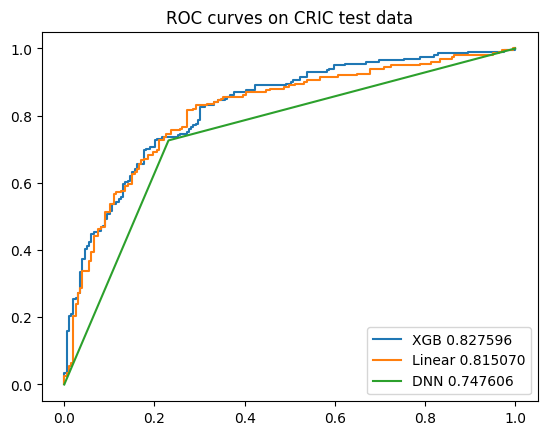

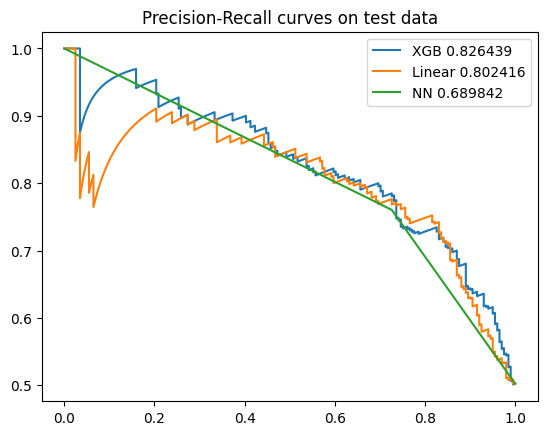

In [19]:
# Compute performance metrics
Y_test1 = Y_test.ravel() # 将Y_test1转换为一维数组
xgb_loss = sklearn.metrics.log_loss(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_loss = sklearn.metrics.log_loss(Y_test1, model_lr.predict_proba(X_test)[:,1])
nn_loss = sklearn.metrics.log_loss(Y_test1, model_mlp.predict(X_test))
# constant_loss = sklearn.metrics.log_loss(Y_test1, np.zeros(len(Y_test1)) * y_strain.mean())
print("xgb_loss", xgb_loss)
print("linear_loss", linear_loss)
print("dnn_loss", nn_loss)
print()

xgb_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, model_mlp.predict(X_test))
#svm_roc_auc = sklearn.metrics.roc_auc_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_roc_auc", xgb_roc_auc)
print("linear_roc_auc", linear_roc_auc)
print("dnn_roc_auc", dnn_roc_auc)
#print("svm_roc_auc", svm_roc_auc)
print()

xgb_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_pr_auc = sklearn.metrics.average_precision_score(Y_test1, model_mlp.predict(X_test))
#svm_pr_auc = sklearn.metrics.average_precision_score(Y_test1, svm_model.predict_proba(X_test))
print("xgb_pr_auc", xgb_pr_auc)
print("linear_pr_auc", linear_pr_auc)
print("dnn_pr_auc", dnn_pr_auc)
#print("svm_pr_auc", svm_pr_auc)
print()

xgb_fpr, xgb_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_fpr, linear_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_fpr, dnn_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, model_mlp.predict(X_test))
#svm_fpr, svm_tpr, thresholds = sklearn.metrics.roc_curve(Y_test1, svm_model.predict_proba(X_test))


pl.plot(xgb_fpr, xgb_tpr, label="XGB %f" % xgb_roc_auc)
pl.plot(linear_fpr, linear_tpr, label="Linear %f" % linear_roc_auc)
pl.plot(dnn_fpr, dnn_tpr, label="DNN %f" % dnn_roc_auc)
#pl.plot(svm_fpr, svm_tpr, label="SVM %f" % svm_roc_auc)
pl.legend()
pl.title("ROC curves on CRIC test data")
pl.show()

xgb_prec, xgb_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_xgb.predict_proba(X_test)[:,1])
linear_prec, linear_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_lr.predict_proba(X_test)[:,1])
dnn_prec, dnn_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, model_mlp.predict(X_test))
#svm_prec, svm_recall, thresholds = sklearn.metrics.precision_recall_curve(Y_test1, svm_model.predict_proba(X_test))

pl.plot(xgb_recall, xgb_prec, label="XGB %f" % xgb_pr_auc)
pl.plot(linear_recall, linear_prec, label="Linear %f" % linear_pr_auc)
pl.plot(dnn_recall, dnn_prec, label="NN %f" % dnn_pr_auc)
#pl.plot(svm_recall, svm_prec, label="SVM %f" % svm_pr_auc)
pl.legend()
pl.title("Precision-Recall curves on test data")
pl.show()

In [20]:
# 用训练好的模型和所有预测正确的样本进行模型可解释性分析

# 训练好的模型

# 所有预测正确的样本


### 将三个模型预测准确的样本选出来分别放入一个样本集中，用于后续可解释性方法对比分析
1. 用训练好的模型预测剩余样本
2. 将所有样本（训练集、测试集、预测集）预测概率与是否预测正确输出，并于样本编号匹配
3. 挑选出预测正确的样本
4. 用不同可解释性方法对不同模型预测正确的样本进行可解释性分析

In [21]:
# 将训练、测试、预测结果与输入一起保存到output文件中
# 训练集
output_train_lr = pd.concat([X_train_withFID, Y_train, pd.Series(model_lr.predict_proba(X_train)[:,1], index=X_train_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
outpt_train_xgb = pd.concat([X_train_withFID, Y_train, pd.Series(model_xgb.predict_proba(X_train)[:,1], index=X_train_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_train_mlp = pd.concat([X_train_withFID, Y_train, pd.Series(model_mlp.predict_proba(X_train)[:,1], index=X_train_withFID.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 测试集
output_test_lr = pd.concat([X_test_withFID, Y_test, pd.Series(model_lr.predict_proba(X_test)[:,1], index=X_test_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_xgb = pd.concat([X_test_withFID, Y_test, pd.Series(model_xgb.predict_proba(X_test)[:,1], index=X_test_withFID.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_test_mlp = pd.concat([X_test_withFID, Y_test, pd.Series(model_mlp.predict_proba(X_test)[:,1], index=X_test_withFID.index, name='probability_1')], axis=1) # 保留预测为1的概率

# 预测集
output_pred_lr = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_lr.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_xgb = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_xgb.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index,name='probability_1')], axis=1) # 保留预测为1的概率
output_pred_mlp = pd.concat([X_pred_withFID_,Y_pred, pd.Series(model_mlp.predict_proba(X_pred)[:,1], index=X_pred_withFID_.index, name='probability_1')], axis=1) # 保留预测为1的概率


# predicted列为预测结果，0为未被淹，1为被淹
# 训练集
output_train_lr['predicted'] = (output_train_lr['probability_1'] >= 0.5).astype(int)
outpt_train_xgb['predicted'] = (outpt_train_xgb['probability_1'] >= 0.5).astype(int)
output_train_mlp['predicted'] = (output_train_mlp['probability_1'] >= 0.5).astype(int)

# 测试集
output_test_lr['predicted'] = (output_test_lr['probability_1'] >= 0.5).astype(int)
output_test_xgb['predicted'] = (output_test_xgb['probability_1'] >= 0.5).astype(int)
output_test_mlp['predicted'] = (output_test_mlp['probability_1'] >= 0.5).astype(int)

# 预测集
output_pred_lr['predicted'] = (output_pred_lr['probability_1'] >= 0.5).astype(int)
output_pred_xgb['predicted'] = (output_pred_xgb['probability_1'] >= 0.5).astype(int)
output_pred_mlp['predicted'] = (output_pred_mlp['probability_1'] >= 0.5).astype(int)


# 判断预测是否正确
# 训练集
output_train_lr['correct'] = (output_train_lr['predicted'] == output_train_lr['label']).astype(int)
outpt_train_xgb['correct'] = (outpt_train_xgb['predicted'] == outpt_train_xgb['label']).astype(int)
output_train_mlp['correct'] = (output_train_mlp['predicted'] == output_train_mlp['label']).astype(int)

# 测试集
output_test_lr['correct'] = (output_test_lr['predicted'] == output_test_lr['label']).astype(int)
output_test_xgb['correct'] = (output_test_xgb['predicted'] == output_test_xgb['label']).astype(int)
output_test_mlp['correct'] = (output_test_mlp['predicted'] == output_test_mlp['label']).astype(int)

# 预测集
output_pred_lr['correct'] = (output_pred_lr['predicted'] == output_pred_lr['label']).astype(int)
output_pred_xgb['correct'] = (output_pred_xgb['predicted'] == output_pred_xgb['label']).astype(int)
output_pred_mlp['correct'] = (output_pred_mlp['predicted'] == output_pred_mlp['label']).astype(int)

# 将预测正确的样本保存在output文件中
# 训练集
output_train_lr_correct = output_train_lr[output_train_lr['correct'] == 1]
outpt_train_xgb_correct = outpt_train_xgb[outpt_train_xgb['correct'] == 1]
output_train_mlp_correct = output_train_mlp[output_train_mlp['correct'] == 1]

# 测试集
output_test_lr_correct = output_test_lr[output_test_lr['correct'] == 1]
output_test_xgb_correct = output_test_xgb[output_test_xgb['correct'] == 1]
output_test_mlp_correct = output_test_mlp[output_test_mlp['correct'] == 1]

# 预测集
output_pred_lr_correct = output_pred_lr[output_pred_lr['correct'] == 1]
output_pred_xgb_correct = output_pred_xgb[output_pred_xgb['correct'] == 1]
output_pred_mlp_correct = output_pred_mlp[output_pred_mlp['correct'] == 1]

# 保存到CSV文件中
# 测试集
output_train_lr_correct.to_csv('output/output_train_lr_correct.csv', index=False)
outpt_train_xgb_correct.to_csv('output/output_train_xgb_correct.csv', index=False)
output_train_mlp_correct.to_csv('output/output_train_mlp_correct.csv', index=False)

# 测试集
output_test_lr_correct.to_csv('output/output_test_lr_correct.csv', index=False)
output_test_xgb_correct.to_csv('output/output_test_xgb_correct.csv', index=False)
output_test_mlp_correct.to_csv('output/output_test_mlp_correct.csv', index=False)

# 预测集
output_pred_lr_correct.to_csv('output/output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct.to_csv('output/output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct.to_csv('output/output_pred_mlp_correct.csv', index=False)

# 将测试集、训练集、预测集结果预测正确的样本保存在一个文件中
output_pred_lr_correct_all = pd.concat([output_train_lr_correct, output_test_lr_correct, output_pred_lr_correct], axis=0)
output_pred_xgb_correct_all = pd.concat([outpt_train_xgb_correct, output_test_xgb_correct, output_pred_xgb_correct], axis=0)
output_pred_mlp_correct_all = pd.concat([output_train_mlp_correct, output_test_mlp_correct, output_pred_mlp_correct], axis=0)

# 保存到CSV文件中
output_pred_lr_correct_all.to_csv('output/all_output_pred_lr_correct.csv', index=False)
output_pred_xgb_correct_all.to_csv('output/all_output_pred_xgb_correct.csv', index=False)
output_pred_mlp_correct_all.to_csv('output/all_output_pred_mlp_correct.csv', index=False)

# 将三个模型都预测对的结果保存在一个文件中
# output_pred_all_correct = pd.merge(output_pred_lr_correct_all, output_pred_xgb_correct_all, output_pred_mlp_correct_all, on='id', how='inner') # 交集 inner join 两个表都有的 id 保留 两个表都有的 id 保留
output_pred_all_correct = pd.merge(output_pred_lr_correct_all, output_pred_xgb_correct_all, on='FID_', how='inner').merge(output_pred_mlp_correct_all, on='FID_', how='inner')
output_pred_all_correct.to_csv('output/output_pred_all_correct.csv', index=False) 


---


### 可解释性方法对比分析

1. 准确性：这是最基本的评估指标，它衡量模型预测结果与实际结果之间的差异。准确性可以通过计算模型预测结果与实际结果之间的误差来衡量。

2. 可解释性：可解释性是一个相对概念，它衡量模型输出结果的可理解程度。不同的可解释性方法可能会产生不同程度的可解释性。

3. 效率：效率是另一个重要的评估指标，它衡量模型在处理数据时所需的时间和资源。效率可以通过计算模型训练和测试所需的时间和资源来衡量。

4. 稳定性：稳定性是另一个重要的评估指标，它衡量模型在不同数据集上表现是否一致。稳定性可以通过计算模型在多个数据集上表现的方差来衡量。

5. 可扩展性：可扩展性是另一个重要的评估指标，它衡量模型在处理大规模数据时是否具有良好的扩展能力。可扩展性可以通过计算模型在处理大规模数据时所需的时间和资源来衡量。

对不同模型预测错误的结果也可以用SHAP进行进一步分析


In [ ]:
def integrated_gradients(start_pt, end_pt, steps, keras_model):
    cols = len(start_pt)
    start_pt = tf.convert_to_tensor(start_pt.reshape(-1, cols))
    end_pt = tf.convert_to_tensor(end_pt.reshape(-1, cols))
    # List of points including first point and final point (so steps + 1 points):
    path_of_integration = [start_pt + (float(i)/steps)*(end_pt-start_pt) for i in range(0, steps+1)]
    # List of gradients, each corresponds to a point:
    grad_list = []
    for i in range(steps+1):
        x_tensor = path_of_integration[i]
        with tf.GradientTape() as t:
            t.watch(x_tensor)
            output = keras_model(x_tensor)
            grad = t.gradient(output, x_tensor)
        grad_list.append(grad[0])
    grads = tf.convert_to_tensor(grad_list, dtype=tf.float64)
    # Trapezoid approximation of integral:
    grads = (grads[:-1] + grads[1:]) / 2.0
    ave_grads = tf.reduce_mean(grads, axis=0)
    # Scale by distance traveled in each dimension:
    ig = (end_pt-start_pt).numpy()*ave_grads.numpy()
    return ig[0,:]

def discrete_ig(start_pt, end_pt, steps, model, model_type):
    # Model type can be "xgboost" or "analytic".
    # Points on the path:
    n_cols = len(start_pt)
    step_pts = [start_pt + (float(i)/steps)*(end_pt-start_pt) for i in range(0,steps)]
    step_pts = np.array(step_pts)
    # Discrete deviations from step_pts for each feature:
    dev_pts = np.zeros((steps*n_cols, len(start_pt)))
    inc = (1/steps) * (end_pt-start_pt)
    row_ind = 0
    for s in range(steps):
        for col_ind in range(n_cols):
            dev_pts[row_ind, :] = step_pts[s,:]
            dev_pts[row_ind, col_ind] = step_pts[s,col_ind] + inc[col_ind]
            row_ind += 1
    dat = np.append(step_pts, dev_pts, axis=0)
    # Make predictions:
    if model_type == "xgboost":
        dmat = xgb.DMatrix(dat)
        y_hat = model.predict(dmat)
    if model_type == "analytic":
        y_hat = model(dat)
    # Sum the y_hat deltas for each deviation for each feature:
    out = np.zeros(n_cols)
    row_ind = steps 
    for s in range(steps):
        base_y_hat = y_hat[s]
        for col_ind in range(n_cols):
            dev_y_hat = y_hat[row_ind]
            out[col_ind] += dev_y_hat - base_y_hat
            row_ind += 1
    return out

In [7]:
pip install azureml-interpret


Note: you may need to restart the kernel to use updated packages.


In [11]:
import lime.lime_tabular
import shap
from interpret_community.tabular_explainer import TabularExplainer
from interpret.ext.glassbox import DiscreteIntegratedGradients

ImportError: cannot import name 'DiscreteIntegratedGradients' from 'interpret.ext.glassbox' (/workspaces/Interpretable_ML_UFSM/.venv/lib/python3.10/site-packages/interpret/ext/glassbox/__init__.py)

In [ ]:
# 重新索引X_test
X1_test = X_test.reset_index(drop=True)
# 确认X_test数据集的大小和索引范围
print(X1_test.shape)
print(X1_test.index)

(400, 7)
RangeIndex(start=0, stop=400, step=1)


In [ ]:
# X1_test第一行
X1_test.iloc[0]


average_max_rainfall    -1.646968
average_2hr_rainfall    -2.223229
average_72hr_rainfall   -1.526050
distance to coast       -0.163248
EV                      -0.840237
TWI                      0.654807
DTW                      0.721748
Name: 0, dtype: float64

In [ ]:
X1_test.columns

Index(['average_max_rainfall', 'average_2hr_rainfall', 'average_72hr_rainfall',
       'distance to coast', 'EV', 'TWI', 'DTW'],
      dtype='object')

## 解释方法对比

In [ ]:
# 构建解释器
explainer_shap = shap.TreeExplainer(model_xgb)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X1_test.values, feature_names=X1_test.columns, class_names=['0', '1'], discretize_continuous=True)

### 解释方法耗时对比 (400个样本)


In [ ]:


# 初始化XGBoost模型和训练数据
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# 初始化TabularExplainer和DiscreteIntegratedGradients解释器
explainer = TabularExplainer(X_train, feature_names=X_train.columns)
interpreter = discrete_ig(explainer)

# 计算整个测试集上的解释并记录时间
import time
start_time = time.time()
interpreter.explain_global(X_test)
end_time = time.time()

print("Time taken to compute Discrete Integrated Gradients on entire test set: ", end_time - start_time, "seconds")

In [ ]:
# XGBoost

# 计算LIME解释在整个训练集上所需的时间
start_time = time.time()
explanations = []
for i in range(len(X1_test)):
    explanation = explainer_lime.explain_instance(X1_test.iloc[i], model_xgb.predict_proba, num_features=7)
    explanations.append(explanation)
total_time = time.time() - start_time


# 计算SHAP解释在整个训练集上所需的时间
start_time_shap = time.time()
shap_values = explainer_shap.shap_values(X1_test)
end_time_shap = time.time()

print("Time taken to explain on XGBoost test set with SHAP:", end_time_shap - start_time_shap, "seconds")
print("Total time for LIME explanations on XGBoost test set: {:.2f} seconds".format(total_time))

Time taken to explain all samples with SHAP: 0.08070898056030273 seconds
Total time for LIME explanations on XGBoost test set: 16.38 seconds


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
# xgbooost模型
explainer_shap = shap.TreeExplainer(model_xgb)
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], discretize_continuous=True)

# 计算训练时间（使用LIME解释）
start_time = time.time()


explainer_lime.explain_instance(X1_test.iloc[0], model_xgb.predict_proba) # LIME解释一个样本的时间
lime_train_time = time.time() - start_time

# 计算训练时间（使用SHAP解释）
start_time = time.time()
explainer_shap.shap_values(X1_test) # SHAP解释整个训练集的时间
shap_train_time = time.time() - start_time

# 输出结果
print("LIME Model_xgb Training Time:", lime_train_time)
print("SHAP Model_xgb Training Time:", shap_train_time)

LIME Model_xgb Training Time: 0.10009098052978516
SHAP Model_xgb Training Time: 0.05269193649291992


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:


# 计算准确率、训练时间、模型稳定性得分和模型可扩展性得分等指标

# 计算准确率（使用LIME解释）
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], discretize_continuous=True)
exp_lime = explainer_lime.explain_instance(X_test[0], model_xgb.predict_proba) # 
lime_model_xgb = exp_lime.local_exp[1]
lime_weights = [x[1] for x in lime_model_xgb]
lime_indices = [x[0] for x in lime_model_xgb]
X_test_lime = X_test[:, lime_indices]
model_xgb_lime = model_xgb
model_xgb_lime.fit(X_train[:, lime_indices], Y_train)
y_pred_lime = model_xgb_lime.predict(X_test_lime)
accuracy_lime = accuracy_score(Y_test, y_pred_lime)

# 计算准确率（使用SHAP解释）
explainer_shap = shap.TreeExplainer(model_xgb)
shap_values = explainer_shap.shap_values(X_test)
shap_model_xgb = np.abs(shap_values).mean(axis=0)
shap_weights = shap_model_xgb / shap_model_xgb.sum()
shap_indices = np.argsort(shap_weights)[::-1][:len(lime_indices)]
X_test_shap = X_test[:, shap_indices]
model_xgb_shap = model_xgb
model_xgb_shap.fit(X_train[:, shap_indices], Y_train)
y_pred_shap = model_xgb_shap.predict(X_test_shap)
accuracy_shap = accuracy_score(Y_test, y_pred_shap)

# 输出结果
print("LIME Model_xgb Accuracy:", accuracy_lime)
print("SHAP Model_xgb Accuracy:", accuracy_shap)



# 计算模型稳定性得分（使用SHAP）
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)
std_dev_shap = np.std(shap_values)

# 计算模型稳定性得分（使用LIME）
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['0', '1'], discretize_continuous=True)
exp_lime = explainer_lime.explain_instance(X_test[0], model_xgb.predict_proba)
std_dev_lime = np.std([exp_lime.local_exp[1][i][1] for i in range(len(exp_lime.local_exp[1]))])


print("SHAP Model_xgb Stability Score:", std_dev_shap)
print("LIME Model_xgb Stability Score:", std_dev_lime)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [ ]:
# 将所有训练集的样本预测后进行解释，可以知道模型是如何学习特征的。
# 在测试集上预测集上的样本进行解释，可以知道模型是如何进行预测的。
# 挑出来不同模型预测正确和错误的样本，可以知道不同模型的差异性，不同模型在哪些方法表现更好或更差。

In [ ]:
# 在进行单个解释的时候挑选那些预测正确的特征


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


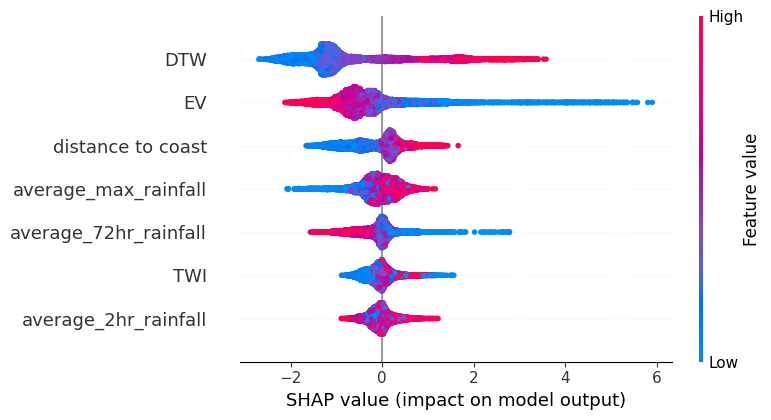

In [ ]:
# TREESHAP

# 初始化SHAP解释器并计算特征重要性，在预测集上分析
explainer = shap.Explainer(model_xgb)
shap_values = explainer(all_output_pred_xgb_correct.iloc[:, 1:-4])

# 绘制汇总图表显示每个特征的重要性
shap.summary_plot(shap_values, all_output_pred_xgb_correct.iloc[:, 1:-4])

# 指标1 runtime 解释1000个预测样本所需的时间

# 指标2 local accuracy 1000个样本中，与模型输出的差异的归一化标准偏差

# 指标3 Consistency guarantees 一致性保证是解释方法的一个理论属性，它确保成对的案例永远一致（属性2）。我们把对这一属性的同意分成三个不同的类别：确切的保证、在无限抽样情况下成立的保证和没有保证。

# 指标4 Keep positive (mask) 指标衡量的是解释方法找到使模型输出增加最多的特征的能力。增加模型输出最多的特征。对于一个单一的输入，最积极的输入特征被保留在它们的原始值上，而所有其他的输入特征被掩盖在它们的平均值上。
# github库 Captum


In [ ]:
# KernelSHAP

In [ ]:
# Individual Conditional Expectation (ICE) https://github.com/AustinRochford/PyCEbox

In [ ]:
# Counterfactual Explanations https://github.com/interpretml/DiCE

In [ ]:
# LIME GitHub代码找到 https://github.com/marcotcr/lime

In [ ]:
# saabas可以加上,nmL那篇文章都加了，我们也可以加，https://github.com/andosa/treeinterpreter
